# <Hsuan-You (Shaun) Lin / hl116 / **HW5**>

## Problem 1: Semantic Segmentation (7 points)
In this problem, you will train a simple semantic segmentation network. Recall that in semantic segmentation, the algorithm must assign each pixel of an input image to one of K object classes. We have provided you with a [Colab notebook](https://colab.research.google.com/drive/1uZB_m8otFmYRAEZZVvsHiQzF8xo72xmm?usp=sharing) with skeleton code to get you started.

We will use a portion of the [CityScapes dataset](https://www.cityscapes-dataset.com/) for this problem, consisting of 2975 training images and 500 validation images. The second cell in the notebook will automatically download the dataset into your local Colab environment.

Each image also comes with annotations for 34 object classes in the form of a segmentation image (with suffix ‘labelIds.png’). The segmentation image contains integer ids in [0, 33] indicating the class of each pixel. [This page](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py) provides the mappings from id to label name.

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import transforms as T
from torchvision import models
from torchvision import datasets

torch.manual_seed(0)
np.random.seed(0)

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/"

Mounted at /content/drive


In [ ]:
# I saved the dataset to my google drive folder, no necessary to download again
!gdown https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4&export=download
!unzip -qq cityscapes.zip

Downloading...
From: https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4
To: /content/cityscapes.zip
100% 651M/651M [00:04<00:00, 159MB/s]
replace __MACOSX/._cityscapes? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### a. 
Fill in the **init** and **forward** functions for the **Segmenter** class, which will implement your segmentation network. The network will be a convolutional encoder-decoder. The encoder will consist of the first several ‘blocks’ of layers extracted from the [VGG16 network](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png) pretrained on ImageNet (the provided Colab notebook extracts these layers for you). You must implement the decoder with this form:

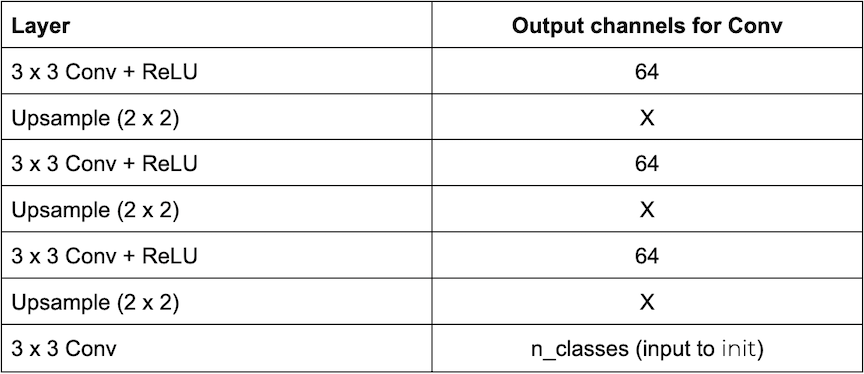

Use PyTorch’s [Upsample function](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html). Remember that the size of the image should not change after each Conv operation (add appropriate padding).

In [2]:
class Segmenter(torch.nn.Module):
    def __init__(self, n_classes, encoder):
        super(Segmenter, self).__init__()
        self.encoder = encoder
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, n_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
      # Encoder
      x = self.encoder(x)

      # Decoder
      x = self.decoder(x)
      return x

In [3]:
class CityScapesDataset(Dataset):
  def __init__(self, images, labels, im_transform, mask_transform):
    self.images = images
    self.labels = labels
    self.im_transform = im_transform
    self.mask_transform = mask_transform
  
  def __getitem__(self, idx):
    im = Image.open(self.images[idx])
    mask = Image.open(self.labels[idx])
    im = self.im_transform(im)[0:3, ...] # Transform image

    # Add an extra first dimension to mask, needed for transforms, convert
    # to LongTensor, and apply transforms to mask.
    mask = np.asarray(mask)[None, ...] 
    mask = torch.LongTensor(mask)
    mask = self.mask_transform(mask)

    # Apply random horizontal flip to image and mask
    if np.random.rand() > 0.5:
      im = TF.hflip(im)
      mask  = TF.hflip(mask)

    return im, mask

  def __len__(self):
    return len(self.images)

In [4]:
batch_size = 16

# Make image and mask transforms.
im_transform = [T.ToTensor()]
im_transform.append(T.Resize((256, 256), interpolation=T.InterpolationMode.BILINEAR))
im_transform = T.Compose(im_transform)

mask_transform = T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)

def get_dataloader(im_path):
  images = sorted(glob.glob(im_path + '/*8bit.jpg'))
  labels = sorted(glob.glob(im_path + '/*labelIds.png'))   
  dataset = CityScapesDataset(images, labels, im_transform, mask_transform)
  return data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Create dataloaders
train_dataloader = get_dataloader(path + '/cityscapes/train')
val_dataloader = get_dataloader(path + '/cityscapes/val')
test_dataloader = get_dataloader(path + '/cityscapes/test')

In [5]:
# Get features from VGG16 up through 3 downsampling (maxpool) operations.
vgg = models.vgg16(pretrained=True);
encoder = nn.Sequential(*(list(vgg.children())[:1])[0][0:17]);

# Create model
n_classes = 34
model = Segmenter(n_classes, encoder);
model.to('cuda');

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]


b. Train your model for 7 epochs using the nn.CrossEntropy loss function. Using the GPU, this should take about 30 minutes.

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [1/7], Train Loss: 1.2251, Val Loss: 0.8387
Saved 0 epoch  model to " /content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_0.params "

----------------------------------------------------------------



/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [2/7], Train Loss: 0.7310, Val Loss: 0.7391
Saved 1 epoch  model to " /content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_1.params "

----------------------------------------------------------------



/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [3/7], Train Loss: 0.6714, Val Loss: 0.6847
Saved 2 epoch  model to " /content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_2.params "

----------------------------------------------------------------



/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [4/7], Train Loss: 0.6342, Val Loss: 0.6668
Saved 3 epoch  model to " /content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_3.params "

----------------------------------------------------------------



/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [5/7], Train Loss: 0.6060, Val Loss: 0.6198
Saved 4 epoch  model to " /content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_4.params "

----------------------------------------------------------------



/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [6/7], Train Loss: 0.5794, Val Loss: 0.6094
Saved 5 epoch  model to " /content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_5.params "

----------------------------------------------------------------



/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Epoch [7/7], Train Loss: 0.5674, Val Loss: 0.5996
Saved 6 epoch  model to " /content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_6.params "

----------------------------------------------------------------



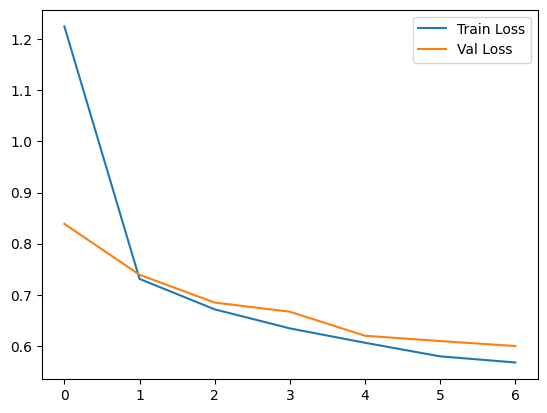

In [6]:
lr = 1e-4
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 7

# Problem 1b: Your training loop code goes here
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # training
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            images = images.to('cuda')
            targets = targets.squeeze().to('cuda') # Squeeze the extra dimension
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to('cuda')
                targets = targets.squeeze().to('cuda') # Squeeze the extra dimension
                outputs = model(images)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)
            epoch_loss = running_loss / len(val_loader.dataset)
            val_losses.append(epoch_loss)
            
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, train_losses[-1], val_losses[-1]))
        
        model_path = path + 'models/model_%d.params' %epoch
        torch.save(model.state_dict(), model_path)
        print('Saved %d epoch ' %epoch, 'model to "', model_path, '"')
        print('\n----------------------------------------------------------------\n')

    return train_losses, val_losses

train_loss, val_loss = train(model, train_dataloader, val_dataloader, loss, optimizer, num_epochs)

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.show()

### c. 
Using the final model, report the [intersection-over-union](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2016/09/iou_equation.png?lossy=1&strip=1&webp=1) (IoU) per class on the validation set in a table. For more on IoU, see [this page](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). Which class has the best IoU, and which has the worst? Comment on why you think certain classes have better accuracies than others, and what factors may cause those differences.

In [7]:
class_names = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 
         'dynamic', 'ground', 'road', 'sidewalk', 'parking', 
         'rail track', 'building', 'wall', 'fence', 'guard rail', 
         'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 
         'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 
         'rider', 'car', 'truck', 'bus', 'caravan', 
         'trailer', 'train', 'motorcycle', 'bicycle']
num_classes = len(class_names)

In [8]:
def compute_iou(pred, target, num_classes):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore classes that are unlabeled
    for cls in range(1, num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return ious

def evaluate(model, dataloader, num_classes):
    ious = []
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            ious_batch = compute_iou(preds, targets, num_classes)
            ious.extend(ious_batch)
    return ious

# Using CPU load the pre-trained model from "/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_6.params"
# model.load_state_dict(torch.load(path+'models/model_6.params', map_location=torch.device('cpu')))

# Using GPU load the pre-trained model from "/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_6.params"
model.load_state_dict(torch.load(path+'models/model_6.params'))

# Evaluate the model on the validation set and print the IoU per class
ious = evaluate(model, val_dataloader, num_classes)
# class_names = val_dataset.class_names
print("IoU per class:")
for i, name in enumerate(class_names):
    print("{}: {:.4f}".format(name, ious[i]))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


IoU per class:
unlabeled: 0.8645
ego vehicle: 0.7691
rectification border: 0.8069
out of roi: 0.0011
static: 0.0000
dynamic: 0.0000
ground: 0.9180
road: 0.5526
sidewalk: 0.0126
parking: 0.0000
rail track: 0.7105
building: 0.1099
wall: 0.1699
fence: nan
guard rail: nan
bridge: nan
tunnel: 0.0479
pole: 0.0000
polegroup: 0.0000
traffic light: 0.1672
traffic sign: 0.7645
vegetation: 0.4574
terrain: 0.7962
sky: 0.2498
person: 0.0000
rider: 0.6633
car: 0.0002
truck: 0.0000
bus: 0.0000
caravan: 0.0000
trailer: nan
train: 0.0000
motorcycle: 0.3224
bicycle: 0.8600


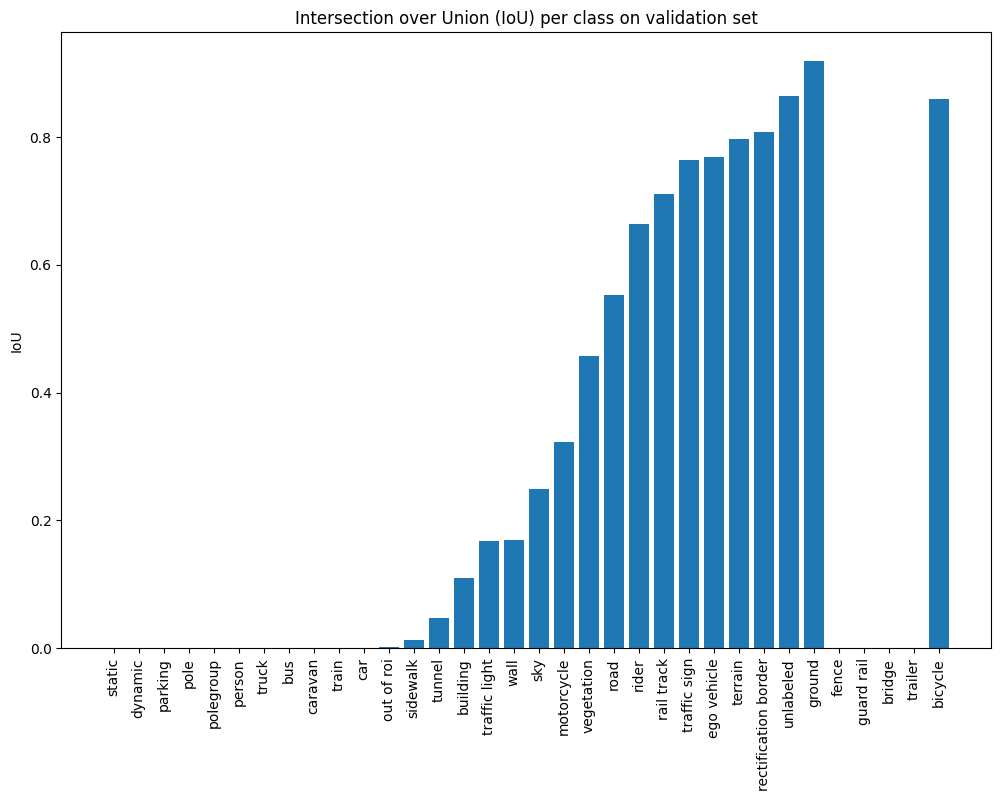

In [9]:
# Create a dictionary with class names as keys and IoU values as values
iou_dict = {class_names[i]: ious[i] for i in range(len(class_names))}

# Sort the dictionary by IoU values
iou_dict_sorted = {k: v for k, v in sorted(iou_dict.items(), key=lambda item: item[1])}

# Plot the results as a bar chart
plt.figure(figsize=(12, 8))
plt.bar(range(len(iou_dict_sorted)), list(iou_dict_sorted.values()), align='center')
plt.xticks(range(len(iou_dict_sorted)), list(iou_dict_sorted.keys()), rotation=90, fontsize=10)
plt.ylabel('IoU')
plt.title('Intersection over Union (IoU) per class on validation set')
plt.show()

### d. 
For each of the following validation images, show three images side-by-side: the image, the ground truth segmentation, and your predicted segmentation. The segmentation images should be in color, with each class represented by a different color.

1.   frankfurt_000000_015389_leftImg8bit.jpg
2.   frankfurt_000001_057954_leftImg8bit.jpg
3.   lindau_000037_000019_leftImg8bit.jpg
4.   munster_000173_000019_leftImg8bit.jpg

<Figure size 640x480 with 0 Axes>

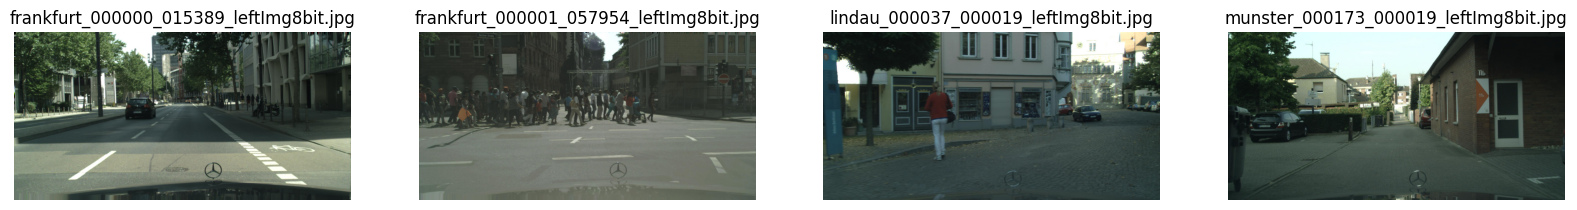

In [10]:
# access the images
img1 = Image.open(path + '/cityscapes/val/frankfurt_000000_015389_leftImg8bit.jpg')
img2 = Image.open(path + '/cityscapes/val/frankfurt_000001_057954_leftImg8bit.jpg')
img3 = Image.open(path + '/cityscapes/val/lindau_000037_000019_leftImg8bit.jpg')
img4 = Image.open(path + '/cityscapes/val/munster_000173_000019_leftImg8bit.jpg')

# display the images
plt.figure()
fig, ax = plt.subplots(1, 4, figsize=(20, 20)) 
output_images = [img1, img2, img3, img4]
titles = ['frankfurt_000000_015389_leftImg8bit.jpg', 
      'frankfurt_000001_057954_leftImg8bit.jpg', 
      'lindau_000037_000019_leftImg8bit.jpg', 
      'munster_000173_000019_leftImg8bit.jpg']
index = 0
for i in range(len(titles)):
  ax[i].imshow(output_images[index])
  ax[i].axis('off')
  ax[i].set_title(f"{titles[index]}")
  index += 1

In [15]:
# Set the seed for random number generation, after tested, 9 will sort the images in order of titles 
torch.manual_seed(9)

# Using CPU load the pre-trained model from "/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_6.params"
# model.load_state_dict(torch.load(path+'models/model_6.params', map_location=torch.device('cpu')))

# Using GPU load the pre-trained model from "/content/drive/MyDrive/Colab Notebooks/COMP546/HW/HW5/models/model_6.params"
model.load_state_dict(torch.load(path+'models/model_6.params'))

# Set the model to evaluation mode
model.eval()

# Initialize empty lists to store the predicted labels, true labels, and input images
y_pred = []
y_true = []
images_list = []

# Iterate over the test data in batches
for batch, (X,y) in enumerate(test_dataloader):
  # Move the inputs and labels to the CPU
  # X = X.to('cpu')
  # y = y.to('cpu')

  # Move the inputs and labels to the cuda
  X = X.to('cuda')
  y = y.to('cuda')

  # Flip the images horizontally
  X = torch.flip(X, dims=[3])
  y = torch.flip(y, dims=[3])

  # Forward pass the inputs through the model and get the predicted labels
  pred = model(X)
  pred = torch.argmax(pred, dim = 1)

  # Append the predicted and true labels, and the input images to their respective lists
  y_pred.extend(pred.cpu().numpy())
  y_true.extend(y.cpu().numpy())
  images_list.extend(X)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
# create a color map for each class
color_map = np.array([
    [0,  0,  0],          # unlabeled
    [0,  0,  0],          # ego vehicle
    [0,  0,  0],          # rectification border
    [0,  0,  0],          # out of roi
    [0,  0,  0],          # static
    [111, 74,  0],         # dynamic
    [81,  0,  81],         # ground
    [128, 64, 128],         # road
    [244, 35, 232],         # sidewalk
    [250, 170, 160],        # parking
    [230, 150, 140],        # rail track
    [70,  70, 70],         # building
    [102, 102, 156],        # wall
    [190, 153, 153],        # fence
    [180, 165, 180],        # guard rail
    [150, 100, 100],        # bridge
    [150, 120, 90],         # tunnel
    [153, 153, 153],        # pole
    [153, 153, 153],        # polegroup
    [250, 170, 30],         # traffic light
    [220, 220,  0],        # traffic sign
    [107, 142, 35],        # vegetation
    [152, 251, 152],       # terrain
    [70, 130, 180],        # sky
    [220, 20, 60],        # person
    [255, 0,  0],        # rider
    [0,  0, 142],        # car
    [0,  0, 70],         # truck
    [0,  60, 100],        # bus
    [0,  0,  90],        # caravan
    [0,  0, 110],        # trailer
    [0,  80, 100],        # train
    [0,  0, 230],        # motorcycle
    [119, 11, 32]         # bicycle
])

<Figure size 640x480 with 0 Axes>

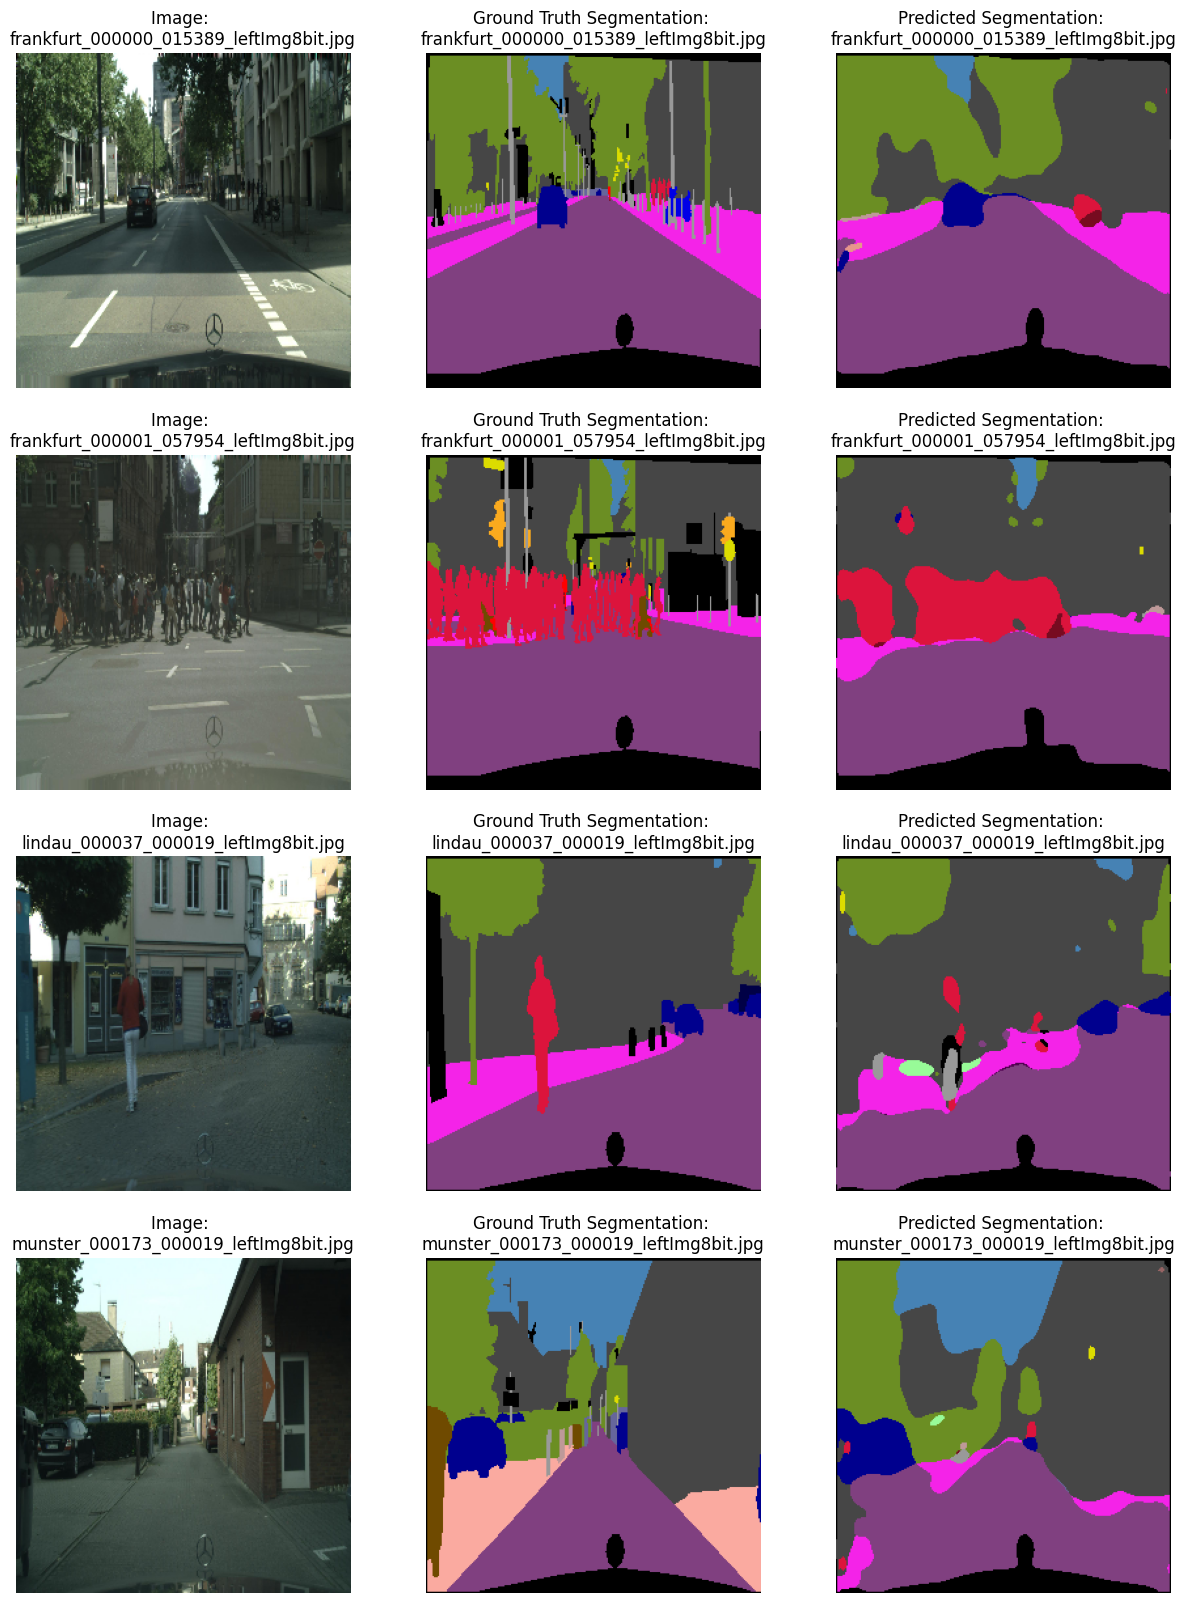

In [16]:
# apply the model to the validation images and display the results
plt.figure()
fig, ax = plt.subplots(len(y_pred), 3, figsize=(15, 20)) 

# iterate over the predicted and true segmentation labels and images
for i, (pred, true, title) in enumerate(zip(y_pred, y_true, titles)):
  h, w = pred.shape

  # create new arrays to store the predicted and true segmentation labels as RGB images
  pred_image = np.zeros((h, w, 3))
  true_image = np.zeros((h, w, 3))

  # iterate over the pixels in the predicted and true segmentation labels and convert them to RGB values
  for y in range(h):
    for x in range(w):
      # get the RGB values for the predicted segmentation label
      pred_image_R, pred_image_G, pred_image_B = color_map[int(pred[y][x])]
      pred_image[y][x][0] = pred_image_R
      pred_image[y][x][1] = pred_image_G
      pred_image[y][x][2] = pred_image_B

      # get the RGB values for the true segmentation label
      true_image_R, true_image_G, true_image_B = color_map[int(true.squeeze(0)[y][x])]
      true_image[y][x][0] = true_image_R
      true_image[y][x][1] = true_image_G
      true_image[y][x][2] = true_image_B

  # display the images
  ax[len(y_pred)-1-i][0].imshow(torch.permute(images_list[i].cpu(),(1,2,0)))
  ax[len(y_pred)-1-i][0].axis('off')
  ax[i][0].set_title('Image: \n' + title)
  
  ax[len(y_pred)-1-i][1].imshow(true_image.astype(np.uint8))
  ax[len(y_pred)-1-i][1].axis('off')
  ax[i][1].set_title('Ground Truth Segmentation: \n' + title)
  
  ax[len(y_pred)-1-i][2].imshow(pred_image.astype(np.uint8))
  ax[len(y_pred)-1-i][2].axis('off')
  ax[i][2].set_title('Predicted Segmentation: \n' + title)
    
plt.show()

### e. 
Look at the lines of code for resizing the images and masks to 256 x 256. We use bilinear interpolation when resizing the image, but nearest neighbor interpolation when resizing the mask. Why do we not use bilinear interpolation for the mask?

**My Answer**: 

We do not use bilinear interpolation for the mask when resizing it to 256 x 256 because the segmentation mask is a categorical map where each pixel is assigned a discrete label indicating the class to which it belongs. If we use bilinear interpolation to resize the mask, it would introduce new values that are not valid class labels and distort the mask, leading to incorrect labels in the output. Nearest neighbor interpolation preserves the integer labels in the mask and is therefore a better choice for resizing categorical maps.

### f. 
Look at the **__getitem__** function for the CityScapesDataset class and notice that we apply a horizontal flip augmentation to the image and mask using a random number generator. Why do we apply the flip in this way instead of simply adding **T.RandomHorizontalFlip** to the sequence of transforms in **im_transform** and **mask_transform** (similar to what you did in Homework 4)

**My Answer**: 

In this project, we apply the horizontal flip augmentation using a random number generator in the __getitem__ function because we want to apply the same random horizontal flip to both the image and mask. If we simply added T.RandomHorizontalFlip to the sequence of transforms in im_transform and mask_transform, we would not be guaranteed that the same flip would be applied to both the image and mask. By applying the flip separately using the random number generator, we ensure that the same flip is applied to both.